# Variational autoencoder network with MedNIST Dataset

This notebook illustrates the use of the variational autoencoder in MONAI for the purpose of image deblurring/denoising.

# Learning objectives
This will go through the steps of using MONAI's in-built VarAutoEncoder.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/varautoencoder_mednist.ipynb)

## Setup environment

In [ ]:
%pip install -q monai["pillow"]

# 1. Imports and configuration

In [1]:
#%matplotlib notebook

import time
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import VarAutoEncoder
from monai.transforms import (
    AddChannelD,
    Compose,
    LoadImageD,
    ScaleIntensityD,
    ToTensorD,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.4.0
Numpy version: 1.19.1
Pytorch version: 1.7.0a0+7036e91
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 7.0.0
Tensorboard version: 2.2.0
gdown version: 3.12.2
TorchVision version: 0.8.0a0
ITK version: 5.1.0
tqdm version: 4.54.1
lmdb version: 1.0.0
psutil version: 5.7.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Create small visualistaion function
def plot_ims(ims, shape=None, figsize=(10,10), titles=None):
    shape = (1,len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i,im in enumerate(ims):
        plt.subplot(*shape,i+1)
        im = plt.imread(im) if isinstance(im, str) else torch.squeeze(im)
        plt.imshow(im, cmap='gray')
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 2. Get the data

This notebook can use the MedNIST or the MNIST datasets.
<br>
<br>
<br>
The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest). 

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/root/data/MONAI


In [5]:
def get_mednist_data(mednist_folder):
    resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
    md5 = "0bc7306e7427e00ad1c5526a6677552d"

    compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
    if not os.path.exists(mednist_folder):
        download_and_extract(resource, compressed_file, root_dir, md5)

In [6]:
def get_mnist_data(mnist_folder):
    if not os.path.exists(mnist_folder):
        os.makedirs(mnist_folder)
    if len(os.listdir(mnist_folder)) < 60000:
        mnist_fname = os.path.join(root_dir, "MNIST.gz")
        if not os.path.exists(mnist_fname):
            mnist_train_url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
            request.urlretrieve(mnist_train_url, mnist_fname)
        f = gzip.open(mnist_fname,'r')
        f.read(16) # Skip first 16 bytes
        image_size = 28
        num_images = 60000
        buf = f.read(image_size * image_size * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, image_size, image_size)

    for i in trange(data.shape[0]):
        im = np.squeeze(data[i])
        rescaled = (255.0 / im.max() * (im - im.min())).astype(np.uint8)
        pil_im = Image.fromarray(rescaled)
        pil_im.save(os.path.join(mnist_folder, f"mnist_{i}.png"))

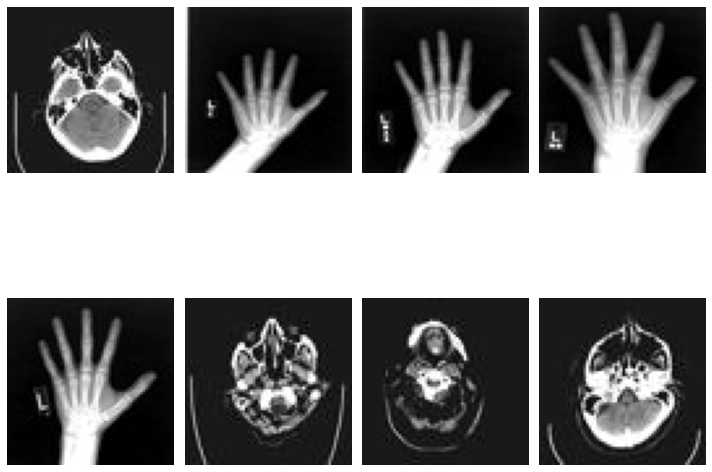

In [7]:
use_mnist = False
if use_mnist:
    im_dir = os.path.join(root_dir, "MNIST")
    get_mnist_data(im_dir)
else:
    data_dir = os.path.join(root_dir, "MedNIST")
    get_mednist_data(data_dir)
    # could be any combination of ["AbdomenCT", "BreastMRI", "CXR", "ChestCT", "Hand", "HeadCT"]
    scan_types = ["Hand", "HeadCT"]
    all_filenames = []
    for scan_type in scan_types:
        im_dir = os.path.join(data_dir, scan_type)
        all_filenames += [os.path.join(im_dir, filename) for filename in os.listdir(im_dir)]
random.shuffle(all_filenames)

# Visualise a few of them
rand_images = np.random.choice(all_filenames, 8, replace=False)
plot_ims(rand_images, shape=(2,4))

In [8]:
# Split into training and testing
test_frac = 0.2
num_ims = len(all_filenames)
num_test = int(num_ims * test_frac)
num_train = num_ims - num_test
train_datadict = [{"im": fname} for fname in all_filenames[:num_train]]
test_datadict = [{"im": fname} for fname in all_filenames[-num_test:]]
print(f"total number of images: {num_ims}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 20000
number of images for training: 16000
number of images for testing: 4000


# 3. Create dataset and dataloader

Hold data and present batches during training.

In [9]:
batch_size = 128
num_workers = 10

transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        ToTensorD(keys=["im"]),
    ]
)

train_ds = CacheDataset(train_datadict, transforms, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = CacheDataset(test_datadict, transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Load and cache transformed data: 100%|██████████| 4000/4000 [00:04<00:00, 942.00it/s]


# 4. Train

For our loss we'll want to use a combination of a reconstruction loss (here, BCE) and KLD. By increasing the importance of the KLD loss with `beta`, we encourage the network to disentangle the latent generative factors.

In [10]:
BCELoss = torch.nn.BCELoss(reduction='sum')

def loss_function(recon_x, x, mu, log_var, beta):
    BCE = BCELoss(recon_x, x)
    KLD = -0.5 * beta * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(in_shape, epoch_num, latent_size, learning_rate, beta):

    model = VarAutoEncoder(
        dimensions=2,
        in_shape=in_shape,
        out_channels=1,
        latent_size=latent_size,
        channels=(16, 32, 64),
        strides=(1, 2, 2),
    ).to(device)

    # Create optimiser
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    
    avg_train_losses = []
    test_losses = []
    
    t = trange(epoch_num, desc=f"epoch 0, average train loss: ?, test loss: ?", leave=True)
    for epoch in t:
        model.train()
        epoch_loss = 0
        for batch_data in train_loader:        
            inputs = batch_data['im'].to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var, _ = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, log_var, beta)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_losses.append(epoch_loss / len(train_loader.dataset))
            
        # Test 
        model.eval()
        test_loss= 0
        with torch.no_grad():
            for batch_data in test_loader:
                inputs = batch_data['im'].to(device)
                recon, mu, log_var, _ = model(inputs)
                # sum up batch loss
                test_loss += loss_function(recon, inputs, mu, log_var, beta).item()
        test_losses.append(test_loss / len(test_loader.dataset))

        t.set_description(f"epoch {epoch + 1}, average train loss: {avg_train_losses[-1]:.4f}, test loss: {test_losses[-1]:.4f}")
    return model, avg_train_losses, test_losses

In [11]:
epoch_num = 50
learning_rate = 1e-4
beta = 100  # KL beta weighting. increase for disentangled VAE 
latent_size = 2
im_shape = transforms(train_datadict[0])['im'].shape  # VAE constructor needs image shape
model, avg_train_losses, test_losses = train(im_shape, epoch_num, latent_size, learning_rate, beta)

epoch 50, average train loss: 1949.8887, test loss: 1964.1245: 100%|██████████| 50/50 [06:07<00:00,  7.35s/it]


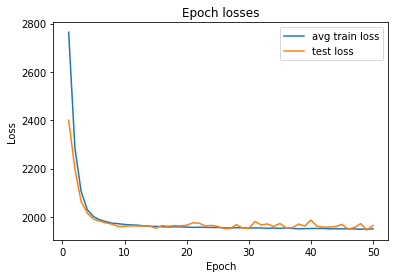

In [12]:
plt.figure()
plt.title("Epoch losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
for y, label in zip([avg_train_losses, test_losses], ['avg train loss', 'test loss']):
    x = list(range(1, len(y)+1))
    line, = plt.plot(x, y)
    line.set_label(label)
plt.legend();

# Scatter plot distribution
Take each of the images in the training and test datasets and plot where they fit into the distribution (for latent size of 2 or 3).

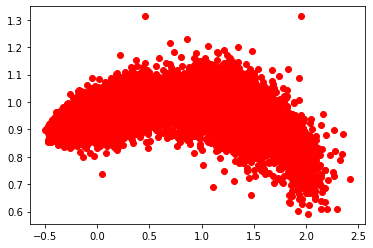

In [13]:
for j, loader in enumerate([train_loader, test_loader]):
    for i, batch_data in enumerate(loader):
        inputs = batch_data['im'].to(device)
        o = model.reparameterize(*model.encode_forward(inputs)).detach().cpu().numpy()
        latent_coords = o if i+j == 0 else np.vstack((latent_coords, o))

if latent_size < 4:
    fig = plt.figure()
    if latent_size == 2:
        plt.scatter(latent_coords[:,0],latent_coords[:,1], c='r', marker='o');
    elif latent_size == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(latent_coords[:,0],latent_coords[:,1],latent_coords[:,2], c='r', marker='o')
        ax.set_xlabel('dim 1')
        ax.set_ylabel('dim 2')
        ax.set_zlabel('dim 3')

# Visualise images produced by sampling the latent space
Visualising high dimensional data can always be tricky. If our latent size is 2, this is easy as we can vary `x` and `y` and see their effect on the generated image. For higher dimension data, one approach might be to vary two of the variables and fix the rest at 0, i.e., create a 2D slice through the N-dimensional data.

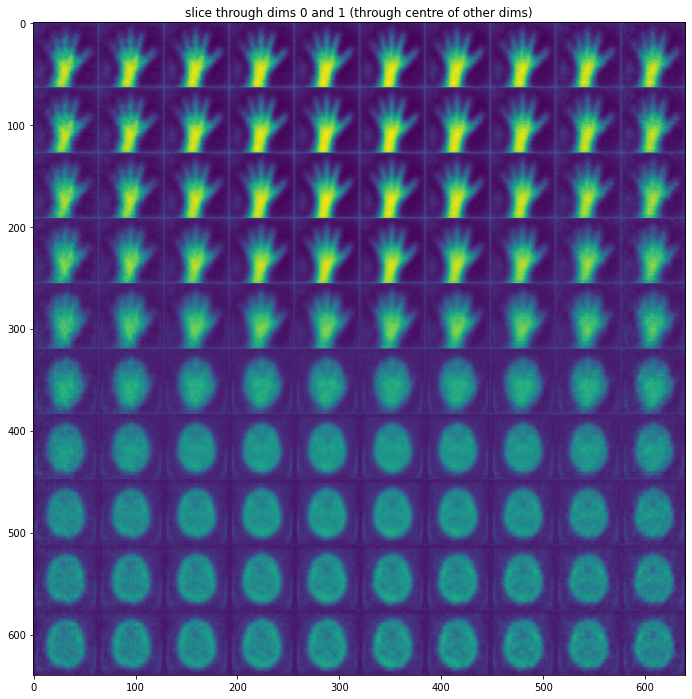

In [14]:
%matplotlib inline
num_ims=10
pl.figure(figsize=(20,12))
out=[[list() for _ in range(num_ims)] for _ in range(latent_size-1)]
dist = torch.distributions.normal.Normal(torch.tensor(0.), torch.tensor(1.))
model.eval()
with torch.no_grad():
    for z in range(latent_size-1):
        for z in range(latent_size-1):
            for y,j in enumerate(torch.linspace(0.05,0.95,num_ims)):
                for x,i in enumerate(torch.linspace(0.05,0.95,num_ims)):
                    sample = torch.zeros(1,latent_size).to(device)
                    sample[0,z] = dist.icdf(j)
                    sample[0,z+1] = dist.icdf(i)
                    o=model.decode_forward(sample)
                    o=o.detach().cpu().numpy().reshape(im_shape[1:])
                    out[z][y].append(o)

slices = np.block(out)
                    
%matplotlib inline
pl.figure(figsize=(20,12))
for i in range(slices.shape[0]):
    pl.imshow(slices[i])
    pl.title(f'slice through dims {i} and {i+1} (through centre of other dims)')
    if slices.shape[0] > 1:
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.1)

### Cleanup data directory

Remove directory if a temporary was used.

In [15]:
if directory is None:
    shutil.rmtree(root_dir)